In [1]:
import pymolpro
import pandas as pd

In [2]:
backend = 'local' 
project_name = 'ICONF_methodtest'
parallel = 32

In [3]:
methods = ['HF', 'MP2', 'MP3','MP4','PAPT;MP2','PAPT;MP3','PAPT;MP4','CCSD','CCSD(T)']
bases = ['cc-pVDZ','cc-pVTZ']

In [4]:
db = pymolpro.database.load("GMTKN55_ICONF")

In [5]:
small=db.subset(open_shell=False,max_electrons=30)
print(small)

GMTKN55 ICONF (closed shell only) (maximum number of electrons 30):

Molecules:
N3H5_1: {'geometry': '           8\n  \n    N         -0.77907197      0.10994832      0.00000000\n    N         -0.03149962      0.01698457      1.22272462\n    N         -0.03149962      0.01698457     -1.22272462\n    H          0.73807619     -0.65953384     -1.13084901\n    H          0.38903766      0.93051636     -1.38896889\n    H          0.73807619     -0.65953384      1.13084901\n    H          0.38903766      0.93051636      1.38896889\n    H         -1.41215648     -0.68588250      0.00000000\n', 'description': 'N3H5_1'}
N3H5_2: {'geometry': '           8\n  \n    N         -0.17184112     -0.55707404      0.30027257\n    N          1.20115329     -0.58382423     -0.10374620\n    N         -0.75671527      0.76298616      0.15935504\n    H         -1.28142531      0.84592998     -0.71555242\n    H         -1.41634923      0.87959036      0.92732319\n    H          1.34067837      0.03520591    

In [6]:
results = {}
for method in methods:
    results[method] = {}
    for basis in bases:
        results[method][basis] = pymolpro.database.run(small,method, basis + '-F12' if 'F12' in method else basis,
                                                       location=project_name, backend=backend,
                                                       preamble="core", parallel=parallel)
        if results[method][basis].failed: print(method, basis, 'failed', results[method][basis].project_directory)
        
print(results) 

{'HF': {'cc-pVDZ': <pymolpro.database.Database object at 0x7f9c4c180190>, 'cc-pVTZ': <pymolpro.database.Database object at 0x7f9c4c183850>}, 'MP2': {'cc-pVDZ': <pymolpro.database.Database object at 0x7f9c4bfbf160>, 'cc-pVTZ': <pymolpro.database.Database object at 0x7f9c4bfbfd90>}, 'MP3': {'cc-pVDZ': <pymolpro.database.Database object at 0x7f9c4bfe8040>, 'cc-pVTZ': <pymolpro.database.Database object at 0x7f9c4bfe8220>}, 'MP4': {'cc-pVDZ': <pymolpro.database.Database object at 0x7f9c4bfe84f0>, 'cc-pVTZ': <pymolpro.database.Database object at 0x7f9c4bfe87f0>}, 'PAPT;MP2': {'cc-pVDZ': <pymolpro.database.Database object at 0x7f9c4bfe8370>, 'cc-pVTZ': <pymolpro.database.Database object at 0x7f9c4bfe8ca0>}, 'PAPT;MP3': {'cc-pVDZ': <pymolpro.database.Database object at 0x7f9c4bfe9960>, 'cc-pVTZ': <pymolpro.database.Database object at 0x7f9cfd7d9090>}, 'PAPT;MP4': {'cc-pVDZ': <pymolpro.database.Database object at 0x7f9c4bfe9db0>, 'cc-pVTZ': <pymolpro.database.Database object at 0x7f9c4bfe95a0>}

In [7]:
analyse=pymolpro.database.analyse([result['cc-pVTZ'] for result in results.values()],small)
analyse['reaction statistics']

,HF/cc-pVTZ,MP2/cc-pVTZ,MP3/cc-pVTZ,MP4/cc-pVTZ,PAPT;MP2/cc-pVTZ,PAPT;MP3/cc-pVTZ,PAPT;MP4/cc-pVTZ,CCSD/cc-pVTZ,CCSD(T)/cc-pVTZ
MAD,0.000653,0.000873,0.000337,0.000903,0.000337,0.000339,0.000771,0.000348,0.000687
MAXD,0.000871,0.001222,0.000531,0.001304,0.000552,0.000550,0.001129,0.000561,0.001037
RMSD,0.000689,0.000940,0.000389,0.000988,0.000400,0.000399,0.000850,0.000408,0.000771
MSD,-0.000653,0.000873,0.000337,0.000903,0.000337,0.000339,0.000771,0.000348,0.000687
STDEVD,0.000307,0.000493,0.000275,0.000567,0.000305,0.000299,0.000507,0.000301,0.000495


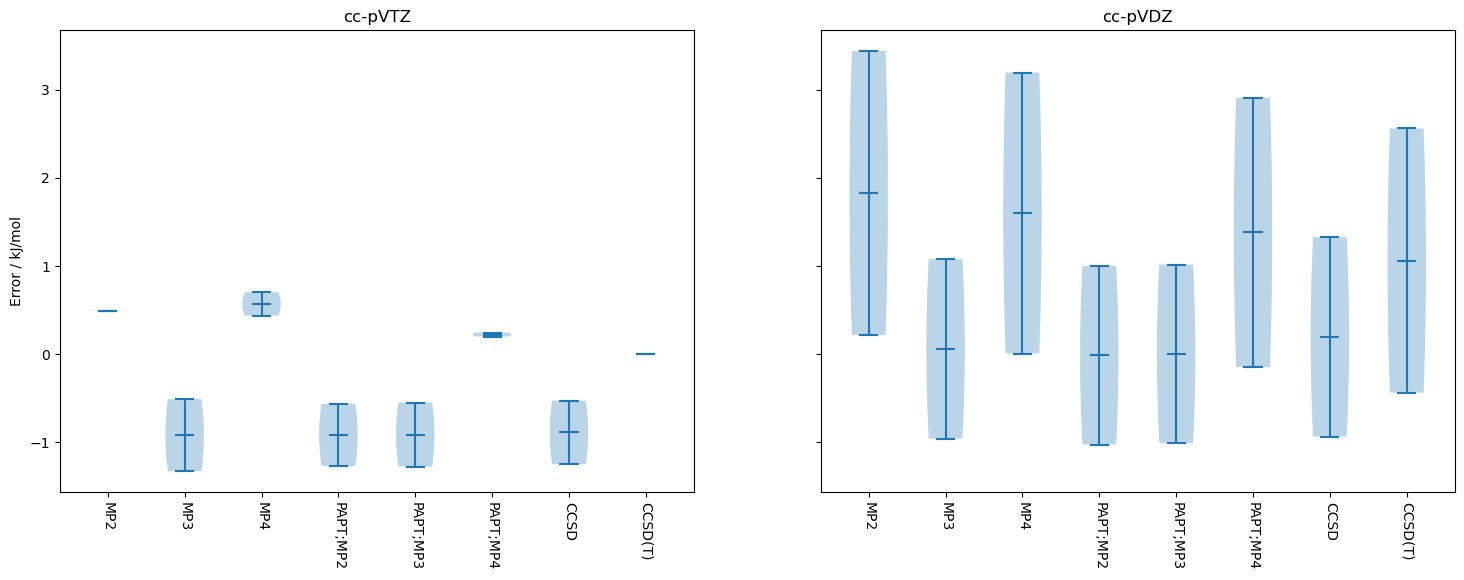

In [8]:
import matplotlib.pyplot as plt

methods_pruned = [method for method in methods if method != 'HF']
bases_pruned = ['cc-pVTZ', 'cc-pVDZ']
fig, panes = plt.subplots(nrows=1, ncols=len(bases_pruned), sharey=True, figsize=(18, 6))

for pane in range(len(bases_pruned)):
    data = []
    for method in methods_pruned:
        data.append(
            pymolpro.database.analyse(results[method][bases_pruned[pane]],
                                      results['CCSD(T)']['cc-pVTZ'],'kJ/mol')['reaction energy deviations'].to_numpy()[:, 0]
        )
    panes[pane].violinplot(data, showmeans=True, showextrema=True, vert=True, bw_method='silverman')
    panes[pane].set_xticks(range(1, len(methods_pruned) + 1), labels=methods_pruned, rotation=-90)
    panes[pane].set_title(bases_pruned[pane])
panes[0].set_ylabel('Error / kJ/mol')
plt.savefig(project_name + ".violin.pdf")
